<a href="https://colab.research.google.com/github/gioliveirass/fatec-AM-airPollutionLevel/blob/main/air_pollution_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 💨 Importando bibliotecas

Importando bibliotecas que serão utilizadas ao longo do desenvolvimento do script.

In [1]:
# Pandas
import pandas as pd

In [2]:
# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [3]:
# Sklearn
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Skforecast
!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.4 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


## 💨 Carregando base de dados

A base de dados utilizada se encontra disponível no [Kaggle](https://www.kaggle.com/datasets/totoro29/air-pollution-level/).

In [5]:
url = 'https://raw.githubusercontent.com/gioliveirass/fatec-AM-airPollutionLevel/main/Air%20Pollution.csv'
data = pd.read_csv(url, sep=',')
data.head(5)

,Country Name,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Updated Year
0,Afghanistan,Kabul,2019,119.77,NaN,NaN,18.0,NaN,NaN,2022
1,Albania,Durres,2015,NaN,17.65,26.63,NaN,NaN,83.961187,2022
2,Albania,Durres,2016,14.32,24.56,24.78,NaN,NaN,87.932605,2022
3,Albania,Elbasan,2015,NaN,NaN,23.96,NaN,NaN,97.853881,2022
4,Albania,Elbasan,2016,NaN,NaN,26.26,NaN,NaN,96.049636,2022


## 💨 Selecionando valores relevantes

Queremos prever o nível da poluição do ar apenas da cidade de São Paulo - Brasil. Além do mais, vamos utilizar somente as partículas de poluição atmosférica PM2.5 (μg/m3) para realizar a predição de nível de poluição do ar.

In [47]:
# Aplicando filtro de país nos dados
country_filter = data["Country Name"] == "Brazil"
filtered_data = data[country_filter]
filtered_data.head(5)

,Country Name,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Updated Year
1864,Brazil,Americana,2011,NaN,37.0,NaN,NaN,NaN,NaN,2018
1865,Brazil,Americana,2012,NaN,34.0,NaN,NaN,NaN,NaN,2018
1866,Brazil,Americana,2013,NaN,33.0,NaN,NaN,NaN,NaN,2018
1867,Brazil,Americana,2014,NaN,36.0,NaN,NaN,NaN,NaN,2018
1868,Brazil,Americana,2016,NaN,36.0,NaN,NaN,NaN,NaN,2018


In [48]:
# Aplicando o filtro de cidade nos dados
city_filter = filtered_data["City"] == "Sao Paulo"
filtered_data = filtered_data[city_filter]
filtered_data.head()

,Country Name,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Updated Year
2271,Brazil,Sao Paulo,2010,17.33,36.62,49.17,NaN,NaN,NaN,2018
2272,Brazil,Sao Paulo,2011,20.25,36.50,42.33,NaN,NaN,NaN,2018
2273,Brazil,Sao Paulo,2012,17.50,34.90,42.33,NaN,NaN,NaN,2018
2274,Brazil,Sao Paulo,2013,16.00,32.73,36.78,NaN,NaN,NaN,2018
2275,Brazil,Sao Paulo,2014,19.14,34.86,39.70,NaN,NaN,NaN,2018


In [49]:
# Removendo colunas que não serão utilizadas
columns_to_remove = ['Country Name', 'City', 'PM10 (μg/m3)', 'NO2 (μg/m3)', 'PM25 temporal coverage (%)', 'PM10 temporal coverage (%)', 'NO2 temporal coverage (%)', 'Updated Year']
filtered_data = filtered_data.drop(columns_to_remove, axis=1)
filtered_data.head()

,Year,PM2.5 (μg/m3)
2271,2010,17.33
2272,2011,20.25
2273,2012,17.50
2274,2013,16.00
2275,2014,19.14


## 💨 Identificando se há algum ruído nos dados filtrados

Se algum ruído (exemplo: valores nulos) for identificado, ele deve ser removido.

In [29]:
# Identificando tipo de valores
filtered_data.dtypes

Year               int64
PM2.5 (μg/m3)    float64
dtype: object

In [32]:
# Identificando se há algum valor nulo
print(filtered_data.isnull().sum())

Year             0
PM2.5 (μg/m3)    0
dtype: int64


## 💨 Ajustando valor da data


In [50]:
# Converte data de string para datetime e transforma em índice
filtered_data['Year'] = pd.to_datetime(filtered_data['Year'], format='%Y')
sorted_data = filtered_data.set_index('Year')
# sorted_data = sorted_data.asfreq('Y')
sorted_data = sorted_data.sort_index()
sorted_data.head

<bound method NDFrame.head of             PM2.5 (μg/m3)
Year                     
2010-01-01          17.33
2011-01-01          20.25
2012-01-01          17.50
2013-01-01          16.00
2014-01-01          19.14
2015-01-01          18.40
2016-01-01          16.60
2018-01-01          17.26
2019-01-01          16.67>

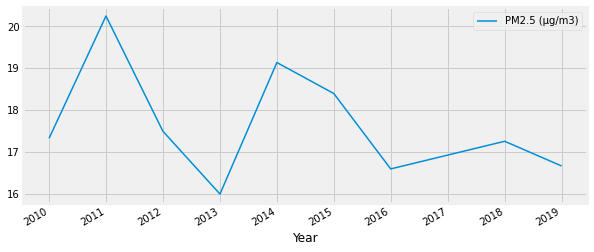

In [51]:
# Plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
sorted_data['PM2.5 (μg/m3)'].plot(ax=ax, label='PM2.5 (μg/m3)')
ax.legend();